## Setup

In [ ]:
!nvidia-smi

Mon Jun 27 18:22:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import matplotlib.pyplot as plt # for plotting
import seaborn as sns
import numpy as np # for transformation

import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
from torch.autograd import Variable 

#!pip install pandas==1.3.0 #1.3.0
import pandas as pd

import glob
!pip3 install pickle5
import pickle5 as pickle
import os

from torch.utils.data import Dataset, DataLoader, random_split, Subset, RandomSampler
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from tqdm import tqdm
#from pandas.core.computation.check import NUMEXPR_INSTALLED

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 4.2 MB/s 


### Five Key Steps
#### 1. Load and normalize the train and test data 
#### 2.Define the Convolutional Neural Network (CNN)
#### 3. Define the loss function and optimizer
#### 4. Train the model on the train data
#### 5. Test the model on the test data

In [ ]:
#Mount Drive to get data
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#set the device to cuda:0 
if torch.cuda.is_available():  
  device = "cuda:0" 
else:  
  device = "cpu"  

## Dataset

In [ ]:
#Load In the Dataset
class EEGDataset(Dataset):

  def __init__(self, data_path, chunk_size=1000):
    """
        Args:
            data_path (string): Directory with the EEG training data. Filenames in this dir must begin with "PD" or "Control" to assign labels correctly. Must be in .csv files. 
            chunk_size (int): Number of datapoints from EEG time series to be included in a single non-overlapping epoch. Note that UNM data was collected at 500Hz.
    """
    #create a list of datafields to keep. The electrodes given here are those in common to both the UI and UNM datasets.
    self.common_electrodes = ['time', 'Fp1', 'Fz', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'FCz', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'POz', 'PO8', 'P6', 'P2', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'F2', 'AF4', 'AF8']

    #create the datapaths
    self.data_path = data_path  
    self.data_list = glob.glob(self.data_path + "*.csv")

    #create containers for the data and labels respectively
    self.df_list = []
    self.label_list = []

    self.files = glob.glob(self.data_path+ '*.csv')

    for file in self.files:

      if os.path.isfile(file):

        
        csv = pd.read_csv(file,sep=',', index_col=[0])
        csv = csv.drop(index=0, inplace=False, axis=0) #drop first row because it's usually noisy
        csv = csv[self.common_electrodes]
        csv = csv.drop('time', inplace=False, axis=1) #drop time so it is not considered as a variable

        #csv is then segmented into epochs. Each epochs is added as a df to the list of data with a corresponding list of labels (at this point the whole filename is given as the label).
        for chunk in range(1,csv.shape[0]//chunk_size +1):
            start = (chunk-1)*chunk_size
            stop = chunk*chunk_size
            self.df_list.append(csv.iloc[start:stop])
            self.label_list.append(file)

    print('there are this many items in the list of data ' ,len(self.df_list))  
    print('there are this many items in the list of labels ' , len(self.label_list))

    #define the labels as vectors
    self.class_map = {"CTL" : [0, 1], "PD": [1, 0]} 
    
    
    #################### Normalization ###############################
    self.all_data = self.df_list[0]
    
    self.normalized_df_list = []
    
    #iterate through each epoch
    for df_index in range(0,len(self.df_list)):
      
      temp_df = self.df_list[df_index]
      mean_by_channel = []
      std_by_channel = []
      
      #determine normalization parameters by column (i.e. for each channel)
      for column in temp_df:
        mean_by_channel.append(temp_df[column].mean())
        std_by_channel.append(temp_df[column].std())

      #apply normalization
      temp_df = temp_df.sub(mean_by_channel, axis='columns')
      temp_df = temp_df.div(std_by_channel, axis='columns')
      self.normalized_df_list.append(temp_df)

    assert (len(std_by_channel)== len(mean_by_channel)), 'length of mean normalization and std normalization are not same length'
    print('The length of the lists of channels means and stds is ', len(mean_by_channel))
    assert ((self.normalized_df_list[0].shape)==(self.df_list[0].shape) and (len(self.normalized_df_list)==len(self.df_list))), 'Normalization changed the shape of the df_list'
    

  #this is a required function that tells you how many data points you have in the dataset
  def __len__(self):
      return len(self.normalized_df_list) 

  #this is a required function that allows you to obtain a single data point according to its index
  def __getitem__(self, idx):
    
    #each dataframe represents one block id
    eeg_dataframe = self.normalized_df_list[idx]
    
    #determine whether that subject is control or PD
    filename = self.label_list[idx].split('/')[-1]
    #this is the string containing the filename. index first 2 chars to see if PD.
    if filename[0:2]=='PD': 
      PD_label = 'PD'
    # then see if its control
    elif filename[0:7]=='Control':
      PD_label = 'CTL'
    # if neither, throw an error
    else:
      print(self.label_list[idx][0:2])
      print(self.label_list[idx][0:7])
      assert False, 'there is a problem finding the label'

    #convert label to tensor using class map
    PD_label = torch.tensor(self.class_map[PD_label], dtype=torch.long)
    
    #reformat the eeg data
    eeg_tensor = torch.tensor(eeg_dataframe[0:chunk_size].values) #set an arbitrary length that cannot be shorter than any of your samples
    eeg_tensor = torch.permute(eeg_tensor,(1, 0))
    
    
    return eeg_tensor.float(), PD_label.float(), filename


## Define the Neural Network

In [ ]:
class PDNet(nn.Module):

    def __init__(self,chunk_size=2500):
        super(PDNet, self).__init__()
        self.chunk_size = chunk_size

        self.conv1 = nn.Conv1d(in_channels=60, out_channels=21, kernel_size=20,stride=1)
        self.norm1 = nn.BatchNorm1d(num_features=21)
        self.maxpool1 = nn.MaxPool1d(kernel_size=4,stride=4)

        self.conv2 = nn.Conv1d(in_channels=21, out_channels=42, kernel_size=10,stride=1)
        self.norm2 = nn.BatchNorm1d(num_features=42)
        self.maxpool2 = nn.MaxPool1d(kernel_size=4,stride=4)

        self.conv3 = nn.Conv1d(in_channels=42, out_channels=42, kernel_size=10,stride=1)
        self.norm3 = nn.BatchNorm1d(num_features=42)
        self.maxpool3 = nn.MaxPool1d(kernel_size=4,stride=4)

        self.conv4 = nn.Conv1d(in_channels=42, out_channels=64, kernel_size=5,stride=1)
        self.norm4 = nn.BatchNorm1d(num_features=64)
        self.maxpool4 = nn.MaxPool1d(kernel_size=4,stride=4)

        
        self.relu = nn.LeakyReLU(0.1)

        
        self.fc1 = nn.Linear(in_features=448,out_features=256)#in_features=4*(self.chunk_size-8)
        self.dropout1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(in_features=256, out_features=64)
        self.dropout2 = nn.Dropout(p=0.5)

        self.fc3 = nn.Linear(in_features=64, out_features=16)
        self.fc4 = nn.Linear(in_features=16, out_features=2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        
        x = self.relu(self.maxpool1(self.norm1(self.conv1(x))))

        x = self.relu(self.maxpool2(self.norm2(self.conv2(x))))
        
        x = self.relu(self.maxpool3(self.norm3(self.conv3(x))))
        
        x = self.relu(self.maxpool4(self.norm4(self.conv4(x))))
        
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimensi
        
        x = self.dropout1(self.fc1(x))
        x = self.dropout2(self.fc2(x))
        x = self.fc3(x)

        x = self.softmax(self.fc4(x))
        return x


In [ ]:
#test the input and output shapes
input_tensor = torch.rand([8,60,2500]).cuda() #of the form [batch_size, channels, epoch_length]
print(input_tensor.size())
network = PDNet().cuda()
output_tensor = network(input_tensor)
print((output_tensor.shape))


torch.Size([8, 60, 2500])
torch.Size([8, 2])


## Train and Validate Methods

In [ ]:
def train(train_dataloader, val_dataloader, epochs=23, learning_rate=0.0001, num_workers=2,  threshold=0.5):
    '''
      INPUTS:
        model(nn.Module): here we will pass PDNet to the training loop.
        train_dataloader(Dataloader): here we will pass the torch.utils.dataloader.Dataloader containing all the training batches. 
        val_dataloader(Dataloader): here we will pass the torch.utils.dataloader.Dataloader containing all the validation batches. 
        epochs(int): the total number of epochs to train for
        learning_rate(float): training hyperparameter defines the rate at which the optimizer will learn
        
      OUTPUTS:
        TP, FP, TN, FN (int): confusion matrix
        vote (str): correct/incorrect
    '''
    #create a model
    model = PDNet(chunk_size=chunk_size).to(device)
    model.train()

    #define loss function and optimizer
    criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.5,0.5]).cuda())
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    #start a timer
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    start.record()
    counter = 0

    ########################## Training ########################################
    for epoch in range(epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        counter = 0
        
        for i, data in enumerate(train_dataloader, 0):
            
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels, filename = data
            inputs, labels = torch.permute(inputs,(0,1,2)).to(device), labels.to(torch.float32).to(device) #send them to the GPU
            
            batch_size = inputs.shape[0]
            # zero the parameter gradients
            optimizer.zero_grad()
            #labels = int(labels)
            # forward 
            outputs = model(inputs)

            #Regularization Replaces pow(2.0) with abs() for L1 regularization
    
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
                  
            #loss + backward + optimize
            loss = criterion(outputs,labels) + l2_lambda*l2_norm
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            counter += 1
        
    ################################ Validation ##############################
    model.eval()
    TP, FP, TN, FN = 0, 0, 0, 0

    for i, data in enumerate(val_dataloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, filename = data
        inputs, labels = torch.permute(inputs,(0,1,2)).to(device), labels.to(torch.float32).to(device) #send them to the GPU
              
        batch_size = inputs.shape[0]

        #forward
        output = model(inputs)

        #binarize output
        output[output>threshold] = 1
        output[output<=threshold] = 0        

        #designate each sample to a confusion matrix label
        for j in range(0,len(output)):
          if (output[j-1,0] == 1) and (labels[j-1,0] == 1):
              TP += 1
          elif(output[j-1,0]==1) and (labels[j-1,0] == 0 ):
              FP += 1
          elif(output[j-1,0]==0) and (labels[j-1,0]== 1):
              FN += 1
          elif(output[j-1,0]==0) and (labels[j-1,0]== 0):
              TN += 1

    #determine whether this subject was predicted correct or incorrect by majority vote
    if (TP + TN) > (FP + FN):
      vote = 'Correct'
    elif (TP + TN) < (FP + FN):
      vote = 'Incorrect'
    else:
      vote ='Unsure'

    # whatever you are timing goes here
    end.record()

    # Waits for everything to finish running
    torch.cuda.synchronize()

    print('The vote was: ', vote)
    print('True Positives: ', TP)
    print('False Positives: ',FP)
    print('True Negatives: ', TN)
    print('False Negatives: ', FN)

    return TP, FP, TN, FN, vote


In [ ]:
#testing the performance
def validate(model, valloader, threshold=0.5, batch_size=8):

  total_loss = 0
  true_positives = 0
  true_negatives = 0
  false_positives = 0
  false_negatives = 0

  true_labels = []
  counter = 0

  #This loads a batch at time
  for i, data in enumerate(valloader, 0):
    #read in data
    inputs, labels, filename = data
    inputs, labels = torch.permute(inputs,(0,1,2)).to(device), labels.to(torch.float32).to(device) #send them to the GPU
    
    #forward
    output = model(inputs)
    criterion = nn.CrossEntropyLoss() 
    
    l2_lambda = 0.0001
    l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())

    total_loss += criterion(output,labels) + l2_lambda*l2_norm 
    counter += 1
  
    output[output>threshold] = 1
    output[output<threshold] = 0

    #designate each sample to a confusion matrix label
    for j in range(0,len(output)):
      if (output[j-1,0] == 1) and (labels[j-1,0] == 1):
          true_positives += 1
      elif(output[j-1,0]==1) and (labels[j-1,0] == 0 ):
          false_positives += 1
      elif(output[j-1,0]==0) and (labels[j-1,0]== 1):
          false_negatives += 1
      elif(output[j-1,0]==0) and (labels[j-1,0]== 0):
          true_negatives += 1
  
  print('true positives: ', true_positives)
  print('false positives: ',false_positives)
  print('true negatives: ',true_negatives)
  print('false negatives', false_negatives)    
  avg_loss = total_loss/counter 
  print("the average validation loss value is: ", avg_loss.item())
  print('--------------------------------------------------')

  return avg_loss.item()

## Main Method/Call Training Loop

In [ ]:
############################ CREATE DATASET ################################
batch_size = 8
num_workers = 2
chunk_size = 2500

#data locations for train/val data
data_src =  '/content/drive/MyDrive/UNM_Data/'

############ create list of subject numbers to leave out ###############################
files = glob.glob(data_src + '*.csv')
leave_one_out_list = []
for file in files:  
  leave_one_out_list.append(file.split('/')[-1].split('_')[1])

############# create dataset of all data ############################
EEG_whole_Dataset = EEGDataset(data_path=data_src, chunk_size=chunk_size)

################################################3

there are this many items in the list of data  2122
there are this many items in the list of labels  2122
The length of the lists of channels means and stds is  60


In [ ]:
##################### CROSS VALIDATION ##############
'''
Here, a for loop will iterate through every object in the whole dataset. Using the filename, it will determine the
subject number for the sample and make two subsets: validation using only the one subject number, and training using all other
subject numbers. It will repeat this for each subject number.
Epochs and Learning rate are adjustable below
'''
correct_votes, incorrect_votes, unsure_votes = 0,0,0
true_positives, false_positives, true_negatives, false_negatives = 0,0,0,0

#leave_out will be 
for leave_out in leave_one_out_list:
  print('Running a fold while leaving out: ', leave_out)
  to_be_removed = []

  for index in range(len(EEG_whole_Dataset)):
    complete_list = range(len(EEG_whole_Dataset))

    subset_ds = Subset(EEG_whole_Dataset, [index])
    sample_sampler = RandomSampler(subset_ds)
    subset_dataloader = DataLoader(subset_ds, sampler=sample_sampler, batch_size=1)
    data = next(iter(subset_dataloader))
    eeg_data, label, filename = data
    subj_id = filename[0].split('_')[1]

    if subj_id == leave_out:
      
      to_be_removed.append(index)

  to_be_kept = [x for x in complete_list if x not in to_be_removed]

  train_dataset = Subset(EEG_whole_Dataset, to_be_kept)
  val_dataset = Subset(EEG_whole_Dataset, to_be_removed)

  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
  del train_dataset, val_dataset #free up memory

  TP, FP, TN, FN, vote = train(train_dataloader, val_dataloader, epochs=30, learning_rate=0.0001, threshold=0.5)
  true_positives += TP
  false_positives += FP
  true_negatives += TN
  false_negatives += FN

  if vote == 'Correct':
    correct_votes += 1
  elif vote == 'Incorrect':
    incorrect_votes += 1
  else:
    unsure_votes +=1

print('total correct subject classifications: ', correct_votes)
print('total incorrect subject classifications: ', incorrect_votes)
print('total unsure subject classifications: ',unsure_votes)
print('total true postives (epochs)', true_positives)
print('total false postives (epochs)', false_positives)
print('total true negatives (epochs)', true_negatives)
print('total false negatives (epochs)', false_negatives)
print('----------------------------------------------------------------')

Running a fold while leaving out:  801
The vote was:  Incorrect
True Positives:  14
False Positives:  0
True Negatives:  0
False Negatives:  20
Running a fold while leaving out:  802


Exception in thread Thread-54:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/pin_memory.py", line 28, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 295, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/pytho

KeyboardInterrupt: ignored

## Evaluation

In [ ]:
def plot_confusion_matrix(TP, FP, TN, FN):
  pred = []
  true = []

  for i in range(TP):
    pred.append(1)
    true.append(1)
  
  for i in range(FP):
    pred.append(1)
    true.append(0)
  
  for i in range(TN):
    pred.append(0)
    true.append(0)

  for i in range(FN):
    pred.append(0)
    true.append(1)

  plt.figure(figsize=(8,6))
  conf_matrix = (confusion_matrix(true, pred))
  # Using Seaborn heatmap to create the plot
  fx = sns.heatmap(conf_matrix,cmap='vlag',annot=True, annot_kws={'fontsize':15},fmt='g')
  
  # labels the title and x, y axis of plot
  #fx.set_title('Plotting Confusion Matrix using Seaborn\n\n');
  fx.set_xlabel('Predicted Values',size=16)
  fx.set_ylabel('Actual Values ', size=16);

  # labels the boxes
  fx.xaxis.set_ticklabels(['CTL','PD'],size=15)
  fx.yaxis.set_ticklabels(['CTL','PD'],size=15)

  plt.show()

In [ ]:

def plot_roc_auc(specificities, sensitivities):
  plt.figure(figsize=(10,8))
  plt.plot((1-np.array(specificities)),sensitivities);
  #plt.title('ROC Curve', size= 20);
  plt.xlabel('1-Specificity', size = 14);
  plt.ylabel('Sensitivity', size = 14);
  plt.legend(['CNN'])
  AUC = auc((1-np.array(specificities)),sensitivities)
  plt.text(0.7,0.2, 'AUC = %f'%AUC, fontsize=10)
  plt.show()


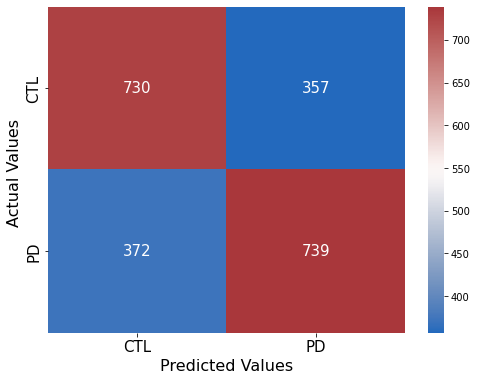

In [ ]:
plot_confusion_matrix(TP=739, FP=357, TN=730, FN=372)